In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os
os.chdir("/content/gdrive/MyDrive/Báo cáo thực tập - Nguyễn Hữu Khải/Rotation")

In [ ]:
!pip install pyunpack
!pip install patool

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pyunpack import Archive
Archive('/content/gdrive/MyDrive/Báo cáo thực tập - Nguyễn Hữu Khải/Rotation/maindata.rar').extractall('/content/gdrive/MyDrive/Báo cáo thực tập - Nguyễn Hữu Khải/Rotation/data/')

In [ ]:
import os
dirs1 = os.listdir("/content/gdrive/MyDrive/Báo cáo thực tập - Nguyễn Hữu Khải/Rotation/data/imagegen")
dirs2 = os.listdir("/content/gdrive/MyDrive/Báo cáo thực tập - Nguyễn Hữu Khải/Rotation/data/maindata")
dirs3 = os.listdir("/content/gdrive/MyDrive/Báo cáo thực tập - Nguyễn Hữu Khải/Rotation/data/valdata")
print(len(dirs1))
print(len(dirs2))
print(len(dirs3))

15000
3028
1172


In [3]:
!pip install torchmetrics
from torch.utils.tensorboard import SummaryWriter
import torchvision
%load_ext tensorboard

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 419 kB 31.7 MB/s 


#Init def train

In [4]:
import time
from tqdm import tqdm
import numpy as np
from statistics import mean
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchmetrics.functional import f1_score
def train_epoch(net, dataloader, lr=0.001, optimizer=None, loss_fn = nn.CrossEntropyLoss()):
  optimizer = optimizer or torch.optim.Adam(net.parameters(), lr = lr)
  net.train()
  total_loss, f1, step = 0,0,0
  for features, labels in dataloader:

    optimizer.zero_grad()
    lbls = labels.to(device)
    out = net(features.to(device))
    loss = loss_fn(out, lbls) #cross_entropy(out, labels)
    loss.backward()
    optimizer.step()
    total_loss +=loss
    # _, predicted = torch.max(out,1)
    f1 += f1_score(out, lbls, num_classes=2)

    step +=1
    """if step % 5 == 0 :
      print(loss.item())"""
  return total_loss.item()/step, f1.item()/step

def validate(net, dataloader, loss_fn = nn.CrossEntropyLoss()):
  net.eval()
  f1, loss, step = 0,0,0
  with torch.no_grad():
    for features, labels in dataloader:
      lbls = labels.to(device)
      out = net(features.to(device))
      loss += loss_fn(out,lbls)
      
      # pred = torch.max(out,1)[1]
      f1 += f1_score(out, lbls, num_classes=2)

      step +=1

  return loss.item()/step, f1.item()/step

def train(net, train_loader, val_loader, optimizer = None, lr = 0.001, epochs = 10, loss_fn = nn.NLLLoss()):
  optimizer = optimizer or torch.optim.Adam(net.parameters(), lr = lr)
  best_f1=0.0
  res = {"train_loss":[], "train_f1":[], "val_loss":[], "val_f1":[]}
  for ep in range(epochs):
    since = time.time()
    
    
    tl,ta = train_epoch(net,train_loader, optimizer = optimizer, lr=lr, loss_fn = loss_fn)
    vl, va = validate(net, val_loader, loss_fn = loss_fn)
    print(f"Epoch {ep}, Train f1 = {ta:.3f}, Val f1 = {va:.3f}, Train loss = {tl:.3f}, Val loss = {vl:.3f}")
    res["train_loss"].append(tl)
    res["train_f1"].append(ta)
    res["val_loss"].append(vl)
    res["val_f1"].append(va)
    if va>best_f1:
        torch.save(model.state_dict(), 'saved_model_lastversion_anhthat1.pth')
        best_f1=va
        
        
    time_elapsed = time.time() - since
    print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    writer.add_scalar('Loss train ', tl, global_step = ep)
    writer.add_scalar('Loss valid ', vl, global_step = ep)
    writer.add_scalar('Accuracy train', ta, global_step = ep)
    writer.add_scalar('Accuracy valid', va, global_step = ep)


  return res
def plot_results(hist):
  plt.figure(figsize = (15,15))
  plt.subplot(1,2,1)
  plt.plot(hist["train_f1"], label = "Training f1")
  plt.plot(hist["val_f1"], label = "Validation f1")
  plt.legend()
  plt.subplot(1,2,2)
  plt.plot(hist["train_loss"], label = "Training loss")
  plt.plot(hist["val_loss"], label = "Validation loss")
  plt.legend()

"""def train(train_loader,valid_loader, net, crit, optim, dev, epochs=0):
  writer = SummaryWriter('runs/text_direct_new')
  min_valid_loss = np.inf
  total_train = 0
  num_corrects = 0
  for e in range(epochs):
    train_loss = 0.0
    model.train()
     
    for data, labels in train_loader:   

        optimizer.zero_grad()
        target = model(data)
        loss = crit(target,labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    valid_loss = 0.0
    model.eval()
         
    for data, labels in valid_loader:
        
        target = model(data)
        loss = crit(target,labels)
        valid_loss += loss.item()
        pred_indices = torch.argmax(target,1)
        total_train += float(labels.size(0))
        num_corrects += (sum(pred_indices == labels)).item()
       
    print(f'Epoch {e+1} \t\t Training Loss: {train_loss/len(train_loader)} \t\t Validation Loss: {valid_loss/len(valid_loader)}\t\t Accuracy:{num_corrects/total_train} ')
    if min_valid_loss > valid_loss:
        print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f}) \t Saving The Model')
        min_valid_loss = valid_loss
        # Saving State Dict
        torch.save(model.state_dict(), 'saved_model.pth')

def train_step(loader, net, crit, optim, dev, total_step, debug_steps=5, epo=0):
    writer = SummaryWriter('runs/text_direct')
    net.train()
    num_corrects = 0
    total_train = 0
    running_loss = 0.0
    running_correct = 0
    tsb = 0
    min_valid_loss = np.inf
    for epoch in range(10): 

      for i, (images,labels) in enumerate(loader):
        images = images.to(dev)
        labels = labels.to(dev)
        optim.zero_grad()

        # Forward pass
        outputs = net(images)

        loss = crit(outputs, labels.type(torch.LongTensor))

        # Backward and optimize
        loss.backward()
        optim.step()

        #Accuracy

        #prob = nn.Softmax(outputs)

        pred_indices = torch.argmax(outputs,1)
        #print(pred_indices)
        total_train += float(labels.size(0))
        num_corrects += (sum(pred_indices == labels)).item()
        running_loss += loss.item()


        if tsb % 100 == 0:    # every 100 mini-batches...

            # ...log the running loss
            writer.add_scalar('training loss',
                            running_loss / 100,
                            epoch * len(loader) + i)
            writer.add_scalar('training accuracy',
                            num_corrects/total_train, i)            
            running_loss = 0  
        tsb = tsb + 1  


        if (i + 1) % debug_steps == 0:
          print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accu: {:.4f}'
                         .format(epo, 50, i + 1, total_step, loss.item(),num_corrects/total_train))"""

class AverageMeter(object):


    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def evaluation(loader, net, crit, dev, thres=0.3, classNum=7):
    net.eval()
    post_pr = ClsPostProcess(['0','90','180','270'])
    mtric = ClsMetric()
    with torch.no_grad():
        total_frame = 0.0
        total_time = 0.0
        running_loss = 0.0
        pbar = tqdm(total=len(loader), desc='eval model:')
        for idx, batch in enumerate(loader):
            if idx >= len(loader):
                break
            images = batch[0].to(dev)
            targets = batch[1].to(dev)
            start = time.time()
            preds = net(images)
            targets = targets.argmax(1)
            loss = crit(preds, targets)
            running_loss += loss.item()
            post_result = post_pr(preds.clone().cpu().numpy(), batch[1].numpy())
            total_time += time.time() - start
            mtric(post_result)
            pbar.update(1)
            total_frame += len(images)
        metirc = mtric.get_metric()

    pbar.close()
    net.train()
    metirc['fps'] = round(total_frame / total_time, 3)
    metirc['loss'] = round(running_loss / len(loader), 3)

    print('val acc: {}, val loss {}, fps {}'.format(metirc['acc'], metirc['loss'], metirc['fps']))
    return metirc



class ClsMetric(object):
    def __init__(self, main_indicator='acc', **kwargs):
        self.main_indicator = main_indicator
        self.reset()

    def __call__(self, pred_label, *args, **kwargs):
        preds, labels = pred_label
        correct_num = 0
        all_num = 0
        for (pred, pred_conf), (target, _) in zip(preds, labels):
            if pred == target:
                correct_num += 1
            all_num += 1
        self.correct_num += correct_num
        self.all_num += all_num
        return {'acc': correct_num / all_num, }

    def get_metric(self):
        """
        return metrics {
                 'acc': 0
            }
        """
        acc = self.correct_num / self.all_num
        self.reset()
        return {'acc': round(acc, 2)}

    def reset(self):
        self.correct_num = 0
        self.all_num = 0


class ClsPostProcess(object):
    """ Convert between text-label and text-index """

    def __init__(self, label_list, **kwargs):
        super(ClsPostProcess, self).__init__()
        self.label_list = label_list

    def __call__(self, preds, label=None, *args, **kwargs):
        if isinstance(preds, torch.Tensor):
            preds = preds.numpy()

        pred_idxs = preds.argmax(axis=1)
        # print('1', preds)
        # print('pred_idxs',pred_idxs)
        decode_out = [(self.label_list[idx], preds[i, idx])
                      for i, idx in enumerate(pred_idxs)]
        if label is None:
            return decode_out
        label = label.argmax(1)
        label = [(self.label_list[idx], 1.0) for idx in label]
        # print(decode_out, label)
        return decode_out, label

# Dataloader


In [18]:
from imgaug.imgaug import imresize_many_images
import os
import cv2
import torch
from torch.utils.data import Dataset
from torchvision.transforms.functional import pad
import numbers
from PIL import Image
import numpy as np
from imgaug import augmenters as iaa
import imgaug as ia
import glob

class RotationDatasetValid0(Dataset):
    def __init__(self, path_image=None, channel=3, transform=None):
        self.transform = transform
        self.list_path_image = glob.glob(path_image + '/*.png')
        self.channel = 3

    def __getitem__(self, index):
        img_path = self.list_path_image[index]
        img = cv2.imread(img_path)
        label = 0            
        if self.transform is not None:
          #print(self.transform, type(img))
          #print(img)
          img = self.transform(image=img)
          #print(img.keys())
          img = img['image']

        return transforms.ToTensor()(img), label

    def __len__(self):
        return len(self.list_path_image)
class RotationDatasetValid1(Dataset):
    def __init__(self, path_image=None, channel=3, transform=None):
        self.transform = transform
        self.list_path_image = glob.glob(path_image + '/*.png')
        self.channel = 3

    def __getitem__(self, index):
        img_path = self.list_path_image[index]
        img = cv2.imread(img_path)
        img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
        label = 1              
        if self.transform is not None:
          #print(self.transform, type(img))
          #print(img)
          img = self.transform(image=img)
          #print(img.keys())
          img = img['image']

        return transforms.ToTensor()(img), label

    def __len__(self):
        return len(self.list_path_image)

class RotationDatasetValid2(Dataset):
    def __init__(self, path_image=None, channel=3, transform=None):
        self.transform = transform
        self.list_path_image = glob.glob(path_image + '/*.png')
        self.channel = 3

    def __getitem__(self, index):
        img_path = self.list_path_image[index]
        img = cv2.imread(img_path)
        img = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
        label = 2              
        if self.transform is not None:
          #print(self.transform, type(img))
          #print(img)
          img = self.transform(image=img)
          #print(img.keys())
          img = img['image']

        return transforms.ToTensor()(img), label

    def __len__(self):
        return len(self.list_path_image)

class RotationDatasetValid3(Dataset):
    def __init__(self, path_image=None, channel=3, transform=None):
        self.transform = transform
        self.list_path_image = glob.glob(path_image + '/*.png')
        self.channel = 3

    def __getitem__(self, index):
        img_path = self.list_path_image[index]
        img = cv2.imread(img_path)
        img = cv2.rotate(img, cv2.ROTATE_180)
        label = 3              
        if self.transform is not None:
          #print(self.transform, type(img))
          #print(img)
          img = self.transform(image=img)
          #print(img.keys())
          img = img['image']

        return transforms.ToTensor()(img), label

    def __len__(self):
        return len(self.list_path_image)

class RotationDataset2(Dataset):
    def __init__(self, path_image=None, channel=3, transform=None):
        self.transform = transform
        self.list_path_image = glob.glob(path_image + '/*.png')
        self.channel = 3

    def __getitem__(self, index):
        img_path = self.list_path_image[index]
        img = cv2.imread(img_path)
        x = np.random.rand()
        if x >= 0 and x<0.5:
          img = cv2.rotate(img, cv2.ROTATE_180)
          label = 1
        else:
          label = 0
        """if x >= 0 and x <= 0.25:
          img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
          label = 1
          
        if x > 0.25 and x <= 0.5:
          img = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
          label = 2
          
        if x > 0.5 and x <= 0.75:
          img = cv2.rotate(img, cv2.ROTATE_180)
          label = 3
        if x > 0.75 and x <=1:
          label = 0"""
               
        if self.transform is not None:
          #print(self.transform, type(img))
          #print(img)
          img = self.transform(image=img)
          #print(img.keys())
          img = img['image']

        return transforms.ToTensor()(img), label

    def __len__(self):
        return len(self.list_path_image)

    def convert_to_one_hot(self, list_label, number_class):
        b = np.zeros((list_label.size, number_class))
        b[np.arange(list_label.size), list_label] = 1
        return b


def get_img_paths(dir_, extensions=('.jpg', '.png', '.jpeg', '.PNG', '.JPG', '.JPEG')):
    img_paths = []
    if type(dir_) is list:
        for d in dir_:
            for root, dirs, files in os.walk(d):
                for file in files:
                    for e in extensions:
                        if file.endswith(e):
                            p = os.path.join(root, file)
                            img_paths.append(p)
    else:
        for root, dirs, files in os.walk(dir_):
            for file in files:
                for e in extensions:
                    if file.endswith(e):
                        p = os.path.join(root, file)
                        img_paths.append(p)
    return img_paths


class NewPad(object):
    def __init__(self, t_size=(64, 128), fill=(255, 255, 255), padding_mode='constant'):
        assert isinstance(fill, (numbers.Number, str, tuple))
        assert padding_mode in ['constant', 'edge', 'reflect', 'symmetric']

        self.fill = fill
        self.padding_mode = padding_mode
        self.t_size = t_size

    def __call__(self, img):
        # def __call__(self, img, t_size):
        target_h, target_w = self.t_size
        # h, w, c = img.shape
        w, h = img.size

        im_scale = h / w
        target_scale = target_h / target_w
        # print(im_scale, target_scale)
        if im_scale < target_scale:
            # keep w, add padding h
            new_w = int(round(target_h / im_scale))
            # new_w =
            out_im = img.resize((new_w, target_h))
            # out_im = img
        else:
            # keep h, add padding w
            new_w = h / target_scale
            _pad = (new_w - w) / 2
            _pad = int(round(_pad))
            padding = (_pad, 0, _pad, 0)  # left, top, right and bottom
            # padding = (0, _pad, 0, _pad)  # left, top, right and bottom
            out_im = pad(img, padding, self.fill, self.padding_mode)
            out_im = out_im.resize((self.t_size[1], self.t_size[0]))
        # print(img.size, out_im.size)
        return out_im

    def __repr__(self):
        return self.__class__.__name__ + '(padding={0}, fill={1}, padding_mode={2})'. \
            format(self.fill, self.padding_mode)


def resize_image(im, size, padding=True, border=cv2.BORDER_CONSTANT, color=[0, 0, 255]):
    # image = cv2.resize(image, size, interpolation=cv2.INTER_LINEAR)
    target_w, target_h = size
    h, w, c = im.shape

    im_scale = h / w
    target_scale = target_h / target_w

    if im_scale < target_scale:
        # keep w, add padding h
        new_h = w * target_scale
        pad = (new_h - h) / 2
        pad = int(pad)
        constant = cv2.copyMakeBorder(im, pad, pad, 0, 0, cv2.BORDER_CONSTANT, value=color)
    elif im_scale > target_scale:
        # keep h, add padding w
        new_w = h / target_scale
        pad = (new_w - w) / 2
        pad = int(pad)
        constant = cv2.copyMakeBorder(im, 0, 0, pad, pad, cv2.BORDER_CONSTANT, value=color)

    image = cv2.resize(constant, size, interpolation=cv2.INTER_LINEAR)
    return image


# Model

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

__all__ = ['MobileNetV3', 'mobilenetv3']


def conv_bn(inp, oup, stride, conv_layer=nn.Conv2d, norm_layer=nn.BatchNorm2d, nlin_layer=nn.ReLU):
    return nn.Sequential(
        conv_layer(inp, oup, 3, stride, 1, bias=False),
        norm_layer(oup),
        nlin_layer(inplace=True)
    )


def conv_1x1_bn(inp, oup, conv_layer=nn.Conv2d, norm_layer=nn.BatchNorm2d, nlin_layer=nn.ReLU):
    return nn.Sequential(
        conv_layer(inp, oup, 1, 1, 0, bias=False),
        norm_layer(oup),
        nlin_layer(inplace=True)
    )


class Hswish(nn.Module):
    def __init__(self, inplace=True):
        super(Hswish, self).__init__()
        self.inplace = inplace

    def forward(self, x):
        return x * F.relu6(x + 3., inplace=self.inplace) / 6.


class Hsigmoid(nn.Module):
    def __init__(self, inplace=True):
        super(Hsigmoid, self).__init__()
        self.inplace = inplace

    def forward(self, x):
        return F.relu6(x + 3., inplace=self.inplace) / 6.


class SEModule(nn.Module):
    def __init__(self, channel, reduction=4):
        super(SEModule, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            Hsigmoid()
            # nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)


class Identity(nn.Module):
    def __init__(self, channel):
        super(Identity, self).__init__()

    def forward(self, x):
        return x


def make_divisible(x, divisible_by=8):
    import numpy as np
    return int(np.ceil(x * 1. / divisible_by) * divisible_by)


class MobileBottleneck(nn.Module):
    def __init__(self, inp, oup, kernel, stride, exp, se=False, nl='RE'):
        super(MobileBottleneck, self).__init__()
        assert stride in [1, 2]
        assert kernel in [3, 5]
        padding = (kernel - 1) // 2
        self.use_res_connect = stride == 1 and inp == oup

        conv_layer = nn.Conv2d
        norm_layer = nn.BatchNorm2d
        if nl == 'RE':
            nlin_layer = nn.ReLU  # or ReLU6
        elif nl == 'HS':
            nlin_layer = Hswish
        else:
            raise NotImplementedError
        if se:
            SELayer = SEModule
        else:
            SELayer = Identity

        self.conv = nn.Sequential(
            # pw
            conv_layer(inp, exp, 1, 1, 0, bias=False),
            norm_layer(exp),
            nlin_layer(inplace=True),
            # dw
            conv_layer(exp, exp, kernel, stride, padding, groups=exp, bias=False),
            norm_layer(exp),
            SELayer(exp),
            nlin_layer(inplace=True),
            # pw-linear
            conv_layer(exp, oup, 1, 1, 0, bias=False),
            norm_layer(oup),
        )

    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)


class MobileNetV3(nn.Module):
    def __init__(self, n_class=1000, input_size=224, dropout=0.8, mode='small', width_mult=1.0):
        super(MobileNetV3, self).__init__()
        input_channel = 16
        # last_channel = 1280
        if mode == 'large':
            # refer to Table 1 in paper
            last_channel = 2048
            mobile_setting = [
                # k, exp, c,  se,     nl,  s,
                [3, 16, 16, False, 'RE', 1],
                [3, 64, 24, False, 'RE', 2],
                [3, 72, 24, False, 'RE', 1],
                [5, 72, 40, True, 'RE', 2],
                [5, 120, 40, True, 'RE', 1],
                [5, 120, 40, True, 'RE', 1],
                [3, 240, 80, False, 'HS', 2],
                [3, 200, 80, False, 'HS', 1],
                [3, 184, 80, False, 'HS', 1],
                [3, 184, 80, False, 'HS', 1],
                [3, 480, 112, True, 'HS', 1],
                [3, 672, 112, True, 'HS', 1],
                [5, 672, 160, True, 'HS', 2],
                [5, 960, 160, True, 'HS', 1],
                [5, 960, 160, True, 'HS', 1],
            ]
        elif mode == 'small':
            # refer to Table 2 in paper
            last_channel = 1024
            mobile_setting = [
                # k, exp, c,  se,     nl,  s,
                [3, 16, 16, True, 'RE', 2],
                [3, 72, 24, False, 'RE', 2],
                [3, 88, 24, False, 'RE', 1],
                [5, 96, 40, True, 'HS', 2],
                [5, 240, 40, True, 'HS', 1],
                [5, 240, 40, True, 'HS', 1],
                [5, 120, 48, True, 'HS', 1],
                [5, 144, 48, True, 'HS', 1],
                [5, 288, 96, True, 'HS', 2],
                [5, 576, 96, True, 'HS', 1],
                [5, 576, 96, True, 'HS', 1],
            ]
        else:
            raise NotImplementedError

        # building first layer
        assert input_size % 32 == 0
        last_channel = make_divisible(last_channel * width_mult) if width_mult > 1.0 else last_channel
        self.features = [conv_bn(3, input_channel, 2, nlin_layer=Hswish)]
        self.classifier = []

        # building mobile blocks
        for k, exp, c, se, nl, s in mobile_setting:
            output_channel = make_divisible(c * width_mult)
            exp_channel = make_divisible(exp * width_mult)
            self.features.append(MobileBottleneck(input_channel, output_channel, k, s, exp_channel, se, nl))
            input_channel = output_channel

        # building last several layers
        if mode == 'large':
            last_conv = make_divisible(960 * width_mult)
            self.features.append(conv_1x1_bn(input_channel, last_conv, nlin_layer=Hswish))
            self.features.append(nn.AdaptiveAvgPool2d(1))
            self.features.append(nn.Conv2d(last_conv, last_channel, 1, 1, 0))
            self.features.append(Hswish(inplace=True))
        elif mode == 'small':
            last_conv = make_divisible(576 * width_mult)
            self.features.append(conv_1x1_bn(input_channel, last_conv, nlin_layer=Hswish))
            # self.features.append(SEModule(last_conv))  # refer to paper Table2, but I think this is a mistake
            self.features.append(nn.AdaptiveAvgPool2d(1))
            self.features.append(nn.Conv2d(last_conv, last_channel, 1, 1, 0))
            self.features.append(Hswish(inplace=True))
        else:
            raise NotImplementedError

        # make it nn.Sequential
        self.features = nn.Sequential(*self.features)

        # building classifier
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),  # refer to paper section 6
            nn.Linear(last_channel, n_class),
            # nn.Linear(last_channel, 640),
            # nn.ReLU(inplace=True),
            # nn.Dropout(p=dropout),  # refer to paper section 6
            # nn.Linear(640, n_class),
        )

        self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
       # print('feat ', x.shape)
        x = x.mean(3).mean(2)
       # print('mean', x.shape)
        x = self.classifier(x)
       # print('cls', x.shape)
        return x

    def _initialize_weights(self):
        # weight initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)


def mobilenetv3(pretrained=False, n_class=7, input_size=320, dropout=0.2, mode='small', width_mult=1.0):
    model = MobileNetV3(n_class, input_size, dropout, mode, width_mult)
    if pretrained:
        state_dict = torch.load(pretrained)
        model.load_state_dict(state_dict, strict=True)
        # raise NotImplementedError
    return model


def get_model(config):
    pretrained = config.MODEL.PRETRAINED
    n_class = config.DATASET.NUM_CLASSES
    dropout = config.TRAIN.DROPOUT
    input_size = config.TRAIN.IMAGE_SIZE[0]
    mode = 'small'
    width_mult = 1.0
    model = mobilenetv3(pretrained=pretrained, n_class=n_class, dropout=dropout, input_size=input_size)
    return model


# Trainer

In [7]:
import albumentations as A

transform_arg=A.Compose([
    A.LongestMaxSize(256),
    A.PadIfNeeded(256,256, border_mode=cv2.BORDER_CONSTANT, value=(255, 255, 255)),
    #A.Resize(256,256),
    #A.HorizontalFlip(p=0.5),
    A.Normalize(),
    #A.IAAAdditiveGaussianNoise (loc=0, scale=(0.01, 0.05), per_channel=False, always_apply=False, p=0.5)
    #A.GaussianBlur(blur_limit=(3, 7), sigma_limit=0, always_apply=False, p=0.5)
])

In [10]:
train_dataset = RotationDataset2("/content/gdrive/MyDrive/Báo cáo thực tập - Nguyễn Hữu Khải/Rotation/data/imagegen", channel=3, transform=transform_arg)
val_dataset0 = RotationDatasetValid0("/content/gdrive/MyDrive/Báo cáo thực tập - Nguyễn Hữu Khải/Rotation/data/maindata", channel=3, transform=transform_arg)
val_dataset1 = RotationDatasetValid1("/content/gdrive/MyDrive/Báo cáo thực tập - Nguyễn Hữu Khải/Rotation/data/maindata", channel=3, transform=transform_arg)
val_dataset2 = RotationDatasetValid2("/content/gdrive/MyDrive/Báo cáo thực tập - Nguyễn Hữu Khải/Rotation/data/maindata", channel=3, transform=transform_arg)
val_dataset3 = RotationDatasetValid3("/content/gdrive/MyDrive/Báo cáo thực tập - Nguyễn Hữu Khải/Rotation/data/maindata", channel=3, transform=transform_arg)
test_dataset = RotationDataset2("/content/gdrive/MyDrive/Báo cáo thực tập - Nguyễn Hữu Khải/Rotation/data/valdata", channel=3, transform=transform_arg)
#val_dataset = val_dataset0 + val_dataset1 + val_dataset2 + val_dataset3
val_dataset = RotationDataset2("/content/gdrive/MyDrive/Báo cáo thực tập - Nguyễn Hữu Khải/Rotation/data/maindata", channel=3, transform=transform_arg)
print(len(train_dataset))
print(len(val_dataset))

15000
3028


In [ ]:
!pip install efficientnet_pytorch
from efficientnet_pytorch import EfficientNet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:
device = 'cuda'
writer = SummaryWriter("runs/text_direct")
train_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=True, num_workers = 16)
val_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True, num_workers = 16)
#model = EfficientNet.from_pretrained('efficientnet-b0').to(device)
#model ._fc= torch.nn.Linear(in_features=model._fc.in_features, out_features=4, bias=True).to(device)
model = mobilenetv3(n_class=2, dropout=0.2, input_size=256).to(device)
model.load_state_dict(torch.load('/content/gdrive/MyDrive/Báo cáo thực tập - Nguyễn Hữu Khải/Rotation/mobilenetv3-Epoch-487-Loss-0.03-Acc-0.99.pth',map_location=torch.device('cpu')))
epochs = 30
learning_rate = 0.003
decay_rate = learning_rate / epochs
optimizer = torch.optim.Adam(lr=learning_rate, params=model.parameters(),weight_decay=decay_rate)
hist = train(model,train_dataloader,val_dataloader,optimizer, epochs=epochs, loss_fn = nn.CrossEntropyLoss())

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 0, Train f1 = 0.759, Val f1 = 0.868, Train loss = 0.536, Val loss = 0.305
2m 37s
Epoch 1, Train f1 = 0.909, Val f1 = 0.950, Train loss = 0.220, Val loss = 0.131
0m 20s
Epoch 2, Train f1 = 0.952, Val f1 = 0.966, Train loss = 0.132, Val loss = 0.096
0m 20s
Epoch 3, Train f1 = 0.961, Val f1 = 0.972, Train loss = 0.101, Val loss = 0.078
0m 20s
Epoch 4, Train f1 = 0.976, Val f1 = 0.984, Train loss = 0.062, Val loss = 0.046
0m 21s
Epoch 5, Train f1 = 0.983, Val f1 = 0.987, Train loss = 0.048, Val loss = 0.043
0m 22s
Epoch 6, Train f1 = 0.982, Val f1 = 0.976, Train loss = 0.052, Val loss = 0.063
0m 20s
Epoch 7, Train f1 = 0.979, Val f1 = 0.991, Train loss = 0.063, Val loss = 0.028
0m 20s
Epoch 8, Train f1 = 0.978, Val f1 = 0.935, Train loss = 0.063, Val loss = 0.123
0m 20s
Epoch 9, Train f1 = 0.981, Val f1 = 0.982, Train loss = 0.052, Val loss = 0.052
0m 21s
Epoch 10, Train f1 = 0.985, Val f1 = 0.988, Train loss = 0.042, Val loss = 0.038
0m 22s
Epoch 11, Train f1 = 0.981, Val f1 = 0.991

In [ ]:
%tensorboard --logdir=runs

In [ ]:
path_image = "/content/gdrive/MyDrive/Báo cáo thực tập - Nguyễn Hữu Khải/Rotation/data/test_rc"
list = glob.glob(path_image + '/*.PNG')
print(list)

['/content/gdrive/MyDrive/Báo cáo thực tập - Nguyễn Hữu Khải/Rotation/data/test_rc/1.PNG', '/content/gdrive/MyDrive/Báo cáo thực tập - Nguyễn Hữu Khải/Rotation/data/test_rc/2.PNG', '/content/gdrive/MyDrive/Báo cáo thực tập - Nguyễn Hữu Khải/Rotation/data/test_rc/Capture.PNG', '/content/gdrive/MyDrive/Báo cáo thực tập - Nguyễn Hữu Khải/Rotation/data/test_rc/3.PNG', '/content/gdrive/MyDrive/Báo cáo thực tập - Nguyễn Hữu Khải/Rotation/data/test_rc/4.PNG', '/content/gdrive/MyDrive/Báo cáo thực tập - Nguyễn Hữu Khải/Rotation/data/test_rc/5.PNG', '/content/gdrive/MyDrive/Báo cáo thực tập - Nguyễn Hữu Khải/Rotation/data/test_rc/7.PNG', '/content/gdrive/MyDrive/Báo cáo thực tập - Nguyễn Hữu Khải/Rotation/data/test_rc/8.PNG', '/content/gdrive/MyDrive/Báo cáo thực tập - Nguyễn Hữu Khải/Rotation/data/test_rc/9.PNG', '/content/gdrive/MyDrive/Báo cáo thực tập - Nguyễn Hữu Khải/Rotation/data

# Test

In [19]:
transform_arg_test=A.Compose([
    A.LongestMaxSize(256),
    A.PadIfNeeded(256,256, border_mode=cv2.BORDER_CONSTANT, value=(255, 255, 255)),
    A.Normalize(),])
test_dataset = RotationDataset2("/content/gdrive/MyDrive/Báo cáo thực tập - Nguyễn Hữu Khải/Rotation/data/imagegen", channel=3, transform=transform_arg_test)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)
print(len(test_dataloader))

15000


In [ ]:
device = 'cuda'
#model = EfficientNet.from_pretrained('efficientnet-b0').to(device)
#model ._fc= torch.nn.Linear(in_features=model._fc.in_features, out_features=4, bias=True).to(device)
model = mobilenetv3(n_class=4, dropout=0.2, input_size=256).to(device)
model.load_state_dict(torch.load('/content/gdrive/MyDrive/Báo cáo thực tập - Nguyễn Hữu Khải/Rotation/saved_model_lastversion_anhthat.pth',map_location=torch.device('cpu')))

<All keys matched successfully>

In [14]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
def predict(model, test_dataloader, device):
  y_pred = []
  y_true = []
  model.eval()
  for inputs, labels in test_dataloader:
    labels = labels.to(device)
    output = model(inputs.to(device)) # Feed Network
    #print(output.shape)

    output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
    y_pred.extend(output) # Save Prediction

    labels = labels.data.cpu().numpy()
    y_true.extend(labels) # Save Truth

  conf_matrix = confusion_matrix(y_true,y_pred)
  fig, ax = plt.subplots(figsize=(7.5, 7.5))
  ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
  for i in range(conf_matrix.shape[0]):
      for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
  plt.xlabel('Predictions', fontsize=18)
  plt.ylabel('Actuals', fontsize=18)
  plt.title('Confusion Matrix', fontsize=18)
  plt.show()
  #print(len(test_dataloader))
  print('Classification Report:')
  print(classification_report(y_true, y_pred))
  return accuracy_score(y_true, y_pred), f1_score(y_true, y_pred, average='macro')

In [ ]:
device = torch.device('cpu')
model = model.to(device)
predict(model, test_dataloader, device)

In [ ]:
!pip install albumentations==0.4.6

In [ ]:
%matplotlib 
import cv2
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow

Using matplotlib backend: agg


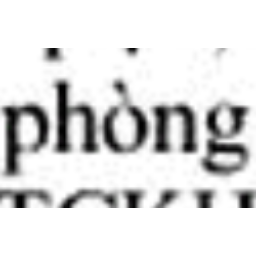

In [ ]:
img_path = "/content/gdrive/MyDrive/Báo cáo thực tập - Nguyễn Hữu Khải/Rotation/data/02_2012_QD-UBND_136145_page43_line147.png"
image = cv2.imread(img_path,cv2.IMREAD_UNCHANGED)
transform = A.Compose([
                      A.LongestMaxSize(256),
                      A.PadIfNeeded(256,256, border_mode=cv2.BORDER_CONSTANT, value=(255, 255, 255)),                    
    ])
img = transform(image=image)['image']
img1 = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
#cv2_imshow(image)
cv2_imshow(img)
#cv2_imshow(img1)

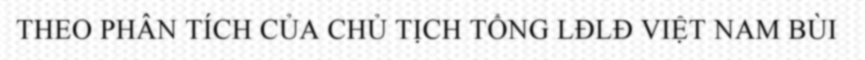

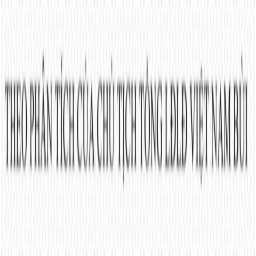

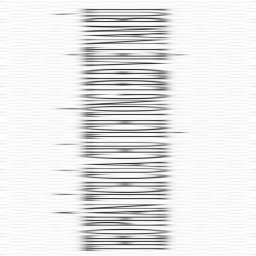

In [ ]:
img_path = "/content/gdrive/MyDrive/Báo cáo thực tập - Nguyễn Hữu Khải/Rotation/data/imagegen/sepecialcharadd10000.png"
image = cv2.imread(img_path,cv2.IMREAD_UNCHANGED)
img = cv2.resize(image,(256,256))
img1 = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)  
cv2_imshow(image)
cv2_imshow(img)
cv2_imshow(img1)

#Tuning parameter


In [ ]:
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [ ]:
device = 'cuda'
model = mobilenetv3(n_class=4, dropout=0.2, input_size=256).to(device)
model.load_state_dict(torch.load('/content/gdrive/MyDrive/Báo cáo thực tập - Nguyễn Hữu Khải/Rotation/saved_model_lastversion_5.pth',map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
def generate_clf_from_search(grid_or_random, model, parameters, scorer, X, y):
    if grid_or_random == "Grid":
        search_obj = GridSearchCV(model, parameters, scoring=scorer)
    elif grid_or_random == "Random":
        search_obj = RandomizedSearchCV(model, parameters, scoring=scorer)
    fit_obj = search_obj.fit(X, y)
    best_clf = fit_obj.best_estimator_
    return best_clf

In [ ]:
model = mobilenetv3(n_class=4, dropout=0.2, input_size=256).to(device)

In [ ]:
!pip install trains
!pip install optuna
!pip install 'ray[tune]'

In [ ]:
from functools import partial
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split
import torchvision
import torchvision.transforms as transforms
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler

In [ ]:
def train_cifar(config, checkpoint_dir="/content/gdrive/MyDrive/Báo cáo thực tập - Nguyễn Hữu Khải/Rotation/saved_model_lastversion_5.pth"):
    net = mobilenetv3(config["l1"], config["l2"])

    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            net = nn.DataParallel(net)
    net.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=config["lr"], momentum=0.9)

    if checkpoint_dir:
        model_state, optimizer_state = torch.load(
            os.path.join(checkpoint_dir, "checkpoint"))
        net.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)

    trainloader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=int(config["batch_size"]),
        shuffle=True,
        num_workers=8)
    valloader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=int(config["batch_size"]),
        shuffle=True,
        num_workers=8)

    for epoch in range(10):  # loop over the dataset multiple times
        running_loss = 0.0
        epoch_steps = 0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            epoch_steps += 1
            if i % 2000 == 1999:  # print every 2000 mini-batches
                print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1,
                                                running_loss / epoch_steps))
                running_loss = 0.0

        # Validation loss
        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0
        for i, data in enumerate(valloader, 0):
            with torch.no_grad():
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = net(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                loss = criterion(outputs, labels)
                val_loss += loss.cpu().numpy()
                val_steps += 1

        with tune.checkpoint_dir(epoch) as checkpoint_dir:
            path = os.path.join(checkpoint_dir, "checkpoint")
            torch.save((net.state_dict(), optimizer.state_dict()), path)

        tune.report(loss=(val_loss / val_steps), accuracy=correct / total)
    print("Finished Training")

In [ ]:
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)

In [ ]:
def test_best_model(best_trial):
    best_trained_model = mobilenetv3(best_trial.config["l1"], best_trial.config["l2"])
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    best_trained_model.to(device)

    checkpoint_path = os.path.join(best_trial.checkpoint.value, "checkpoint")

    model_state, optimizer_state = torch.load(checkpoint_path)
    best_trained_model.load_state_dict(model_state)


    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_dataloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = best_trained_model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()


    print("Best trial test set accuracy: {}".format(correct / total))

In [ ]:
!pip install ray torch torchvision

In [ ]:
def main(num_samples=10, max_num_epochs=10, gpus_per_trial=1):
    config = {
        "l1": tune.sample_from(lambda _: 2 ** np.random.randint(2, 9)),
        "l2": tune.sample_from(lambda _: 2 ** np.random.randint(2, 9)),
        "lr": tune.loguniform(1e-4, 1e-1),
        "batch_size": tune.choice([2, 4, 8, 16])
    }

    
    scheduler = ASHAScheduler(
        max_t=max_num_epochs,
        grace_period=1,
        reduction_factor=2)
    
    result = tune.run(
        tune.with_parameters(train_cifar),
        resources_per_trial={"cpu": 2, "gpu": gpus_per_trial},
        config=config,
        metric="loss",
        mode="min",
        num_samples=num_samples,
        scheduler=scheduler
    )

    best_trial = result.get_best_trial("loss", "min", "last")
    print("Best trial config: {}".format(best_trial.config))
    print("Best trial final validation loss: {}".format(
        best_trial.last_result["loss"]))
    print("Best trial final validation accuracy: {}".format(
        best_trial.last_result["accuracy"]))

    if ray.util.client.ray.is_connected():
        # If using Ray Client, we want to make sure checkpoint access
        # happens on the server. So we wrap `test_best_model` in a Ray task.
        # We have to make sure it gets executed on the same node that
        # ``tune.run`` is called on.
        from ray.tune.utils.util import force_on_current_node
        remote_fn = force_on_current_node(ray.remote(test_best_model))
        ray.get(remote_fn.remote(best_trial))
    else:
        test_best_model(best_trial)

In [ ]:
main()

#Load anh loi


In [ ]:
!pip install albumentations==0.4.6
import albumentations 
from albumentations.pytorch import ToTensorV2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Load anh sai
# Load image
# Transform image
# Reshape -> (C, H, W) -> (1, C, H, W)

import albumentations as A
import torchvision.transforms as transforms
import glob
def predict_image(model,img_path,device):
  count0 = 0
  count1 = 0
  count2 = 0
  countF = 0
  countT = 0
  for filename in glob.iglob(img_path):
    image = cv2.imread(filename)
    x = np.random.rand()
    if x >= 0 and x <= 0.25:
      image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
      label = 1
      
    if x > 0.25 and x <= 0.5:
      image = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
      label = 2
      
    if x > 0.5 and x <= 0.75:
      image = cv2.rotate(image, cv2.ROTATE_180)
      label = 3

    if x > 0.75 and x <=1:
      label = 0

    transform = A.Compose([
                      A.LongestMaxSize(256),
                      A.PadIfNeeded(256,256, border_mode=cv2.BORDER_CONSTANT, value=(255, 255, 255)),
                      A.Normalize(),
                      A.pytorch.transforms.ToTensorV2(),
    ])

    transformed = transform(image=image)['image']
    c,h,w = transformed.shape
    img = transformed.reshape(1,c,h,w)
    img = img.to(device)
    output = model(img)
    output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
    if output != label:
      countF += 1
      #print(label, output, filename)
    if output == label:
      countT += 1
      """if (output == 3 and label == 0) or (output == 0 and label == 3):
        count0 += 1
        print(label, output, filename)
      if (output == 2 and label == 1) or (output == 1 and label == 2):
        count1 += 1
        print(label, output, filename)
      if output == 3 and label != 3:
        count2 += 1
       
  
  print("So lan sai giua 3 va 0 la: ",count0)
  print("So lan sai giua 2 va 1 la: ",count1)
  print("So lan nhan nham thanh 3 la:",count2)"""

  print(countT)
  print(countF)


In [ ]:
device = torch.device('cuda')
#model = EfficientNet.from_pretrained('efficientnet-b0').to(device)
#model ._fc= torch.nn.Linear(in_features=model._fc.in_features, out_features=4, bias=True).to(device)
model.load_state_dict(torch.load('/content/gdrive/MyDrive/Báo cáo thực tập - Nguyễn Hữu Khải/Rotation/saved_model_lastversion_7.pth',map_location=torch.device('cpu')))
predict_image(model=model,img_path="/content/gdrive/MyDrive/Báo cáo thực tập - Nguyễn Hữu Khải/Rotation/data/maindata/*.png",device=device)

684
2344


In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
count_parameters(model)

1513756